# Readmission Risk for Heart Failure Patients

In [1]:
import mimicfouretl.bigquery_utils as bq
from mimicfouretl.data_insights import display_datasets
from mimicfouretl.query_builder import QueryBuilder
from mimicfouretl.feature_engineering import FeatureEngineering
from mimicfouretl.feature_engineering import left_merge_dataframes

from pyspark.sql.functions import col

from mimicfouretl.ml_utils import MLUtils

## Build BigQuery Spark session

In [2]:
tables = bq.list_tables('mimiciv_hosp', use_local_data=True)
tables

['mimiciv_hosp.hcpcsevents',
 'mimiciv_hosp.patients',
 'mimiciv_hosp.emar',
 'mimiciv_hosp.d_hcpcs',
 'mimiciv_hosp.pharmacy',
 'mimiciv_hosp.emar_detail',
 'mimiciv_hosp.d_labitems',
 'mimiciv_hosp.prescriptions',
 'mimiciv_hosp.diagnoses_icd',
 'mimiciv_hosp.transfers',
 'mimiciv_hosp.d_icd_diagnoses',
 'mimiciv_hosp.poe',
 'mimiciv_hosp.omr',
 'mimiciv_hosp.procedures_icd',
 'mimiciv_hosp.microbiologyevents',
 'mimiciv_hosp.poe_detail',
 'mimiciv_hosp.labevents',
 'mimiciv_hosp.services',
 'mimiciv_hosp.d_icd_procedures',
 'mimiciv_hosp.admissions']

In [3]:
display_datasets()

Dropdown(description='Dataset:', options=('hosp.pharmacy', 'hosp.provider', 'hosp.poe_detail', 'hosp.admission…

Output()

In [4]:
spark = bq.get_spark_session(use_local_data=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/30 16:39:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Get relevant ICD codes and Lab Item IDs

### Get ICD codes for heart failure diagnoses

In [5]:
qb_heart_failure_codes = QueryBuilder(dataset='hosp.d_icd_diagnoses', 
                                      columns=['icd_code', 'icd_version', 'long_title'],
                                      filters="LOWER(long_title) LIKE '%heart failure%'")
heart_failure_codes_query = qb_heart_failure_codes.generate_query()
print(heart_failure_codes_query)

SELECT icd_version, long_title, icd_code
FROM `mimiciv_hosp.d_icd_diagnoses`
WHERE LOWER(long_title) LIKE '%heart failure%'


In [6]:
heart_failure_icd_items = bq.run_query(spark, heart_failure_codes_query, use_local_data=True)

24/03/30 16:39:28 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
heart_failure_icd_items.toPandas()

,icd_version,long_title,icd_code
0,9,Chronic systolic heart failure,42822
1,9,"Diastolic heart failure, unspecified",42830
2,9,Acute on chronic systolic heart failure,42823
3,9,"Hypertensive heart and chronic kidney disease, unspecified, with heart failure and with chronic kidney disease stage I through stage IV, or unspecified",40491
4,9,Chronic combined systolic and diastolic heart failure,42842
5,9,"Combined systolic and diastolic heart failure, unspecified",42840
6,9,Acute on chronic combined systolic and diastolic heart failure,42843
7,9,Acute systolic heart failure,42821
8,9,"Systolic heart failure, unspecified",42820
9,9,Unspecified hypertensive heart disease without heart failure,40290


In [8]:
heart_failure_icd_codes_list = [row['icd_code'] for row in heart_failure_icd_items.select('icd_code').distinct().collect()]

In [9]:
heart_failure_icd_codes_str = "'" + "', '".join(heart_failure_icd_codes_list) + "'"

### Get itemids for BNP labs
#### Removed BNP filter

In [10]:
qb_bnp_labs = QueryBuilder(dataset='hosp.d_labitems', 
                           columns=['itemid', 'label', 'fluid', 'category'],
                           filters=["LOWER(label) LIKE '%bnp%'", "fluid = 'Blood'"])
bnp_labs_query = qb_bnp_labs.generate_query()
print(bnp_labs_query)

SELECT label, fluid, category, itemid
FROM `mimiciv_hosp.d_labitems`
WHERE LOWER(label) LIKE '%bnp%' AND fluid = 'Blood'


In [11]:
bnp_lab_items = bq.run_query(spark, bnp_labs_query, use_local_data=True)

In [12]:
bnp_lab_items.toPandas()

,label,fluid,category,itemid
0,NTproBNP,Blood,Chemistry,50963


In [13]:
bnp_lab_itemids_list = [row['itemid'] for row in bnp_lab_items.select('itemid').distinct().collect()]

In [14]:
bnp_lab_itemids_str = ', '.join(str(itemid) for itemid in bnp_lab_itemids_list)

## Query MIMIC IV database for Heart Failure diagnoses and BNP labs

In [15]:
# Initialize QueryBuilders
qb_diagnoses = QueryBuilder(dataset='hosp.diagnoses_icd', 
                            columns=['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version'],
                            filters=f'icd_code IN ({heart_failure_icd_codes_str})')

qb_labevents = QueryBuilder(dataset='hosp.labevents', 
                            columns=['subject_id', 'hadm_id', 'itemid', 'valuenum', 'ref_range_lower', 'ref_range_upper'],
                            filters=f'itemid IN ({bnp_lab_itemids_str})')

# Join datasets
qb_diagnoses.join_with(qb_labevents, join_type='inner', columns=['subject_id', 'hadm_id'])

# Generate query for joined data
qualifying_hosp_admissions_query = qb_diagnoses.generate_query(limit=100000)
# This query can now be used to extract the relevant joined data
print(qualifying_hosp_admissions_query)

SELECT ref_range_upper, `mimiciv_hosp.diagnoses_icd`.hadm_id, valuenum, `mimiciv_hosp.diagnoses_icd`.subject_id, icd_version, itemid, ref_range_lower, seq_num, icd_code
FROM `mimiciv_hosp.diagnoses_icd`
INNER JOIN `mimiciv_hosp.labevents` ON `mimiciv_hosp.diagnoses_icd`.subject_id = `mimiciv_hosp.labevents`.subject_id AND `mimiciv_hosp.diagnoses_icd`.hadm_id = `mimiciv_hosp.labevents`.hadm_id
WHERE icd_code IN ('I119', 'I5021', 'I5033', 'I509', '42842', '42830', 'I130', 'I5032', '4280', 'I5042', '42833', 'I5043', 'I110', '42821', '42840', 'I5022', 'I5084', 'I5020', '42832', 'I5023', '42841', '40491', '42843', '42822', '40290', 'I5031', 'I5030', '42823', '42831', '42820', 'I1310', 'I132', 'I5082') AND itemid IN (50963)
LIMIT 100000


In [16]:
qualifying_hosp_admissions_df = bq.run_query(spark, qualifying_hosp_admissions_query, use_local_data=True)

## Create binary feature checking if BNP value is outside of reference range

In [17]:
feature_engineer = FeatureEngineering(qualifying_hosp_admissions_df)

In [18]:
condition_str = "(valuenum < ref_range_lower) OR (valuenum > ref_range_upper)"
feature_engineer.create_conditional_feature(condition_str, "bnp_outside_ref_range")

In [19]:
qualifying_hosp_admissions_df = feature_engineer.get_processed_data()
qualifying_hosp_admissions_df.toPandas()

,ref_range_upper,hadm_id,valuenum,subject_id,icd_version,itemid,ref_range_lower,seq_num,icd_code,bnp_outside_ref_range
0,229.0,21011631,NaN,13466375,10,50963,0.0,4,I110,0
1,229.0,21011631,NaN,13466375,10,50963,0.0,6,I5021,0
2,93.0,23951090,NaN,10516278,9,50963,0.0,20,4280,0
3,229.0,26491363,2627.0,19155768,10,50963,0.0,2,I5043,1
4,229.0,26491363,2627.0,19155768,10,50963,0.0,1,I130,1
...,...,...,...,...,...,...,...,...,...,...
88,229.0,20515577,8032.0,12643557,10,50963,0.0,1,I132,1
89,229.0,20515577,8032.0,12643557,10,50963,0.0,2,I5023,1
90,852.0,27634119,30061.0,17175688,10,50963,0.0,1,I130,1
91,852.0,27634119,30061.0,17175688,10,50963,0.0,2,I5023,1


## Get admissions data, filtered by Subject ID of Qualifying Patients

In [20]:
qualifying_hosp_admissions_subject_ids_list = [row['subject_id'] for row in qualifying_hosp_admissions_df.select('subject_id').distinct().collect()]

In [21]:
len(qualifying_hosp_admissions_subject_ids_list)

30

In [22]:
qualifying_hosp_admissions_subject_ids_str = ', '.join(str(subject_id) for subject_id in qualifying_hosp_admissions_subject_ids_list)

In [23]:
# Initialize QueryBuilders
qb_admissions = QueryBuilder(dataset='hosp.admissions',
                             filters=f'subject_id IN ({qualifying_hosp_admissions_subject_ids_str})')

# Generate query for joined data
admissions_query = qb_admissions.generate_query(limit=100000)
# This query can now be used to extract the relevant joined data
#print(admissions_query)

In [24]:
admissions_df = bq.run_query(spark, admissions_query, use_local_data=True)

In [25]:
admissions_df.toPandas()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,13466375,21011631,2149-08-30 04:30:00,2149-09-29 18:29:00,NaT,URGENT,P72AYZ,TRANSFER FROM HOSPITAL,ACUTE HOSPITAL,Medicare,ENGLISH,None,WHITE,NaT,NaT,0
1,10326798,23870114,2165-07-14 01:36:00,2165-07-23 16:00:00,NaT,URGENT,P44WVR,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,?,MARRIED,WHITE,NaT,NaT,0
2,10062617,28054611,2117-09-01 21:35:00,2117-09-04 14:41:00,NaT,URGENT,P49NLZ,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,NaT,NaT,0
3,10516278,23645520,2165-07-01 13:19:00,2165-07-06 18:14:00,NaT,URGENT,P15Q8N,TRANSFER FROM HOSPITAL,HOME,Medicaid,?,SINGLE,HISPANIC/LATINO - HONDURAN,2165-07-01 10:33:00,2165-07-01 16:11:00,0
4,10516278,23951090,2165-07-13 15:31:00,2165-08-16 16:35:00,NaT,URGENT,P03YMR,TRANSFER FROM HOSPITAL,HOME,Medicaid,?,SINGLE,HISPANIC/LATINO - HONDURAN,NaT,NaT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,16571048,27747997,2182-10-26 07:15:00,2182-10-28 16:00:00,NaT,SURGICAL SAME DAY ADMISSION,P66L9Y,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,SINGLE,WHITE,NaT,NaT,0
200,15365815,22588375,2159-05-28 02:27:00,2159-06-01 16:58:00,NaT,SURGICAL SAME DAY ADMISSION,P41R5N,PHYSICIAN REFERRAL,SKILLED NURSING FACILITY,Other,ENGLISH,DIVORCED,BLACK/AFRICAN AMERICAN,NaT,NaT,0
201,11206626,28828052,2197-09-27 07:15:00,2197-09-29 16:13:00,NaT,SURGICAL SAME DAY ADMISSION,P88F8W,PHYSICIAN REFERRAL,SKILLED NURSING FACILITY,Medicare,ENGLISH,WIDOWED,WHITE,NaT,NaT,0
202,12199669,20695706,2139-09-30 09:15:00,2139-10-08 13:11:00,NaT,SURGICAL SAME DAY ADMISSION,P48VXK,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,SINGLE,WHITE,NaT,NaT,0


## Count Previous Admissions for Qualifying Patients

In [26]:
feature_engineer = FeatureEngineering(admissions_df)

In [27]:
feature_engineer.count_previous_events(
    partition_column='subject_id',
    order_column='admittime',
    event_column='hadm_id'
)

In [28]:
admissions_df = feature_engineer.get_processed_data()
admissions_df.toPandas()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,previous_hadm_id
0,10062617,28054611,2117-09-01 21:35:00,2117-09-04 14:41:00,NaT,URGENT,P49NLZ,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,NaT,NaT,0,0
1,10062617,27056234,2119-10-30 11:41:00,2119-11-02 16:00:00,NaT,EW EMER.,P534S8,EMERGENCY ROOM,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,2119-10-30 05:29:00,2119-10-30 12:50:00,0,1
2,10062617,21220659,2120-05-13 20:36:00,2120-05-17 17:50:00,NaT,EW EMER.,P822ME,EMERGENCY ROOM,SKILLED NURSING FACILITY,Other,ENGLISH,MARRIED,WHITE,2120-05-13 15:54:00,2120-05-13 21:35:00,0,2
3,10062617,24425655,2121-08-13 18:08:00,2121-08-17 17:57:00,NaT,EW EMER.,P072C5,EMERGENCY ROOM,SKILLED NURSING FACILITY,Other,ENGLISH,MARRIED,WHITE,2121-08-13 15:26:00,2121-08-13 19:22:00,0,3
4,10062617,20308229,2122-02-07 05:30:00,2122-02-11 15:40:00,NaT,EW EMER.,P586YL,EMERGENCY ROOM,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,2122-02-06 22:52:00,2122-02-07 06:40:00,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,19501510,28553932,2188-06-20 19:06:00,2188-06-26 14:00:00,NaT,EW EMER.,P19YR4,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,SINGLE,WHITE,2188-06-20 16:47:00,2188-06-20 20:09:00,0,0
200,19501510,22025039,2188-07-02 12:51:00,2188-07-10 14:45:00,NaT,DIRECT EMER.,P18R3Y,PHYSICIAN REFERRAL,HOSPICE,Medicare,ENGLISH,SINGLE,WHITE,NaT,NaT,0,1
201,19501510,24722368,2188-11-14 22:07:00,2188-11-20 12:30:00,NaT,EW EMER.,P756LT,EMERGENCY ROOM,HOSPICE,Medicare,ENGLISH,SINGLE,WHITE,2188-11-14 19:53:00,2188-11-14 23:20:00,0,2
202,19501510,25247416,2189-02-26 03:05:00,2189-02-27 14:00:00,NaT,EW EMER.,P52TGZ,EMERGENCY ROOM,HOME,Medicare,ENGLISH,SINGLE,WHITE,2189-02-25 20:52:00,2189-02-26 04:57:00,0,3


## Check for Readmission within 30, 90, and 180 days

In [29]:
feature_engineer.check_event_within_timeframe(
    partition_column='subject_id',
    event_column='admittime', 
    timeframe=30
)

In [30]:
feature_engineer.check_event_within_timeframe(
    partition_column='subject_id',
    event_column='admittime', 
    timeframe=90
)

In [31]:
feature_engineer.check_event_within_timeframe(
    partition_column='subject_id',
    event_column='admittime', 
    timeframe=180
)

In [32]:
admissions_df = feature_engineer.get_processed_data()
admissions_df.toPandas()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,race,edregtime,edouttime,hospital_expire_flag,previous_hadm_id,next_admittime_date,days_to_next_admittime,admittime_within_30_days,admittime_within_90_days,admittime_within_180_days
0,10062617,28054611,2117-09-01 21:35:00,2117-09-04 14:41:00,NaT,URGENT,P49NLZ,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,...,WHITE,NaT,NaT,0,0,2119-10-30 11:41:00,789.0,0,0,0
1,10062617,27056234,2119-10-30 11:41:00,2119-11-02 16:00:00,NaT,EW EMER.,P534S8,EMERGENCY ROOM,HOME HEALTH CARE,Other,...,WHITE,2119-10-30 05:29:00,2119-10-30 12:50:00,0,1,2120-05-13 20:36:00,196.0,0,0,0
2,10062617,21220659,2120-05-13 20:36:00,2120-05-17 17:50:00,NaT,EW EMER.,P822ME,EMERGENCY ROOM,SKILLED NURSING FACILITY,Other,...,WHITE,2120-05-13 15:54:00,2120-05-13 21:35:00,0,2,2121-08-13 18:08:00,457.0,0,0,0
3,10062617,24425655,2121-08-13 18:08:00,2121-08-17 17:57:00,NaT,EW EMER.,P072C5,EMERGENCY ROOM,SKILLED NURSING FACILITY,Other,...,WHITE,2121-08-13 15:26:00,2121-08-13 19:22:00,0,3,2122-02-07 05:30:00,178.0,0,0,1
4,10062617,20308229,2122-02-07 05:30:00,2122-02-11 15:40:00,NaT,EW EMER.,P586YL,EMERGENCY ROOM,HOME HEALTH CARE,Other,...,WHITE,2122-02-06 22:52:00,2122-02-07 06:40:00,0,4,2123-07-01 11:27:00,509.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,19501510,28553932,2188-06-20 19:06:00,2188-06-26 14:00:00,NaT,EW EMER.,P19YR4,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,...,WHITE,2188-06-20 16:47:00,2188-06-20 20:09:00,0,0,2188-07-02 12:51:00,12.0,1,1,1
200,19501510,22025039,2188-07-02 12:51:00,2188-07-10 14:45:00,NaT,DIRECT EMER.,P18R3Y,PHYSICIAN REFERRAL,HOSPICE,Medicare,...,WHITE,NaT,NaT,0,1,2188-11-14 22:07:00,135.0,0,0,1
201,19501510,24722368,2188-11-14 22:07:00,2188-11-20 12:30:00,NaT,EW EMER.,P756LT,EMERGENCY ROOM,HOSPICE,Medicare,...,WHITE,2188-11-14 19:53:00,2188-11-14 23:20:00,0,2,2189-02-26 03:05:00,104.0,0,0,1
202,19501510,25247416,2189-02-26 03:05:00,2189-02-27 14:00:00,NaT,EW EMER.,P52TGZ,EMERGENCY ROOM,HOME,Medicare,...,WHITE,2189-02-25 20:52:00,2189-02-26 04:57:00,0,3,2189-06-27 17:02:00,121.0,0,0,1


## Merge Admissions data with Qualifying Admissions data

In [33]:
merged_df = left_merge_dataframes(qualifying_hosp_admissions_df, admissions_df, ['subject_id', 'hadm_id'])

In [34]:
merged_df.toPandas()

,ref_range_upper,hadm_id,valuenum,subject_id,icd_version,itemid,ref_range_lower,seq_num,icd_code,bnp_outside_ref_range,...,race,edregtime,edouttime,hospital_expire_flag,previous_hadm_id,next_admittime_date,days_to_next_admittime,admittime_within_30_days,admittime_within_90_days,admittime_within_180_days
0,229.0,21011631,NaN,13466375,10,50963,0.0,4,I110,0,...,WHITE,NaT,NaT,0,0,NaT,NaN,0,0,0
1,229.0,21011631,NaN,13466375,10,50963,0.0,6,I5021,0,...,WHITE,NaT,NaT,0,0,NaT,NaN,0,0,0
2,93.0,23951090,NaN,10516278,9,50963,0.0,20,4280,0,...,HISPANIC/LATINO - HONDURAN,NaT,NaT,0,21,2165-10-17 17:52:00,96.0,0,0,1
3,229.0,26491363,2627.0,19155768,10,50963,0.0,2,I5043,1,...,WHITE,2180-04-06 21:06:00,2180-04-07 02:02:00,0,15,2180-12-31 04:37:00,268.0,0,0,0
4,229.0,26491363,2627.0,19155768,10,50963,0.0,1,I130,1,...,WHITE,2180-04-06 21:06:00,2180-04-07 02:02:00,0,15,2180-12-31 04:37:00,268.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,229.0,20515577,8032.0,12643557,10,50963,0.0,1,I132,1,...,WHITE,NaT,NaT,0,3,2166-06-12 11:38:00,26.0,1,1,1
89,229.0,20515577,8032.0,12643557,10,50963,0.0,2,I5023,1,...,WHITE,NaT,NaT,0,3,2166-06-12 11:38:00,26.0,1,1,1
90,852.0,27634119,30061.0,17175688,10,50963,0.0,1,I130,1,...,BLACK/AFRICAN AMERICAN,2172-02-14 17:05:00,2172-02-14 23:31:00,0,18,2172-03-12 19:54:00,27.0,1,1,1
91,852.0,27634119,30061.0,17175688,10,50963,0.0,2,I5023,1,...,BLACK/AFRICAN AMERICAN,2172-02-14 17:05:00,2172-02-14 23:31:00,0,18,2172-03-12 19:54:00,27.0,1,1,1


## Get Patient Data for Qualifying Patients

In [35]:
# Initialize QueryBuilders
qb_patients = QueryBuilder(dataset='hosp.patients',
                           columns=['subject_id', 'gender', 'anchor_age'],
                           filters=f'subject_id IN ({qualifying_hosp_admissions_subject_ids_str})')

# Generate query for joined data
patients_query = qb_patients.generate_query(limit=100000)
# This query can now be used to extract the relevant joined data
# print(patients_query)

In [36]:
patients_df = bq.run_query(spark, patients_query, use_local_data=True)

In [37]:
patients_df.toPandas()

,subject_id,gender,anchor_age
0,16571048,M,54
1,12199669,M,56
2,14861499,F,65
3,19155768,M,65
4,17277045,F,66
5,10326798,F,67
6,11040759,M,67
7,13664731,M,71
8,11206626,F,83
9,15060872,F,86


### Merge Patients Data

In [38]:
merged_df = left_merge_dataframes(merged_df, patients_df, ['subject_id'])

## Create Demographic Features

In [39]:
feature_engineer = FeatureEngineering(merged_df)

In [40]:
condition_str = "LOWER(gender) LIKE '%m%'"
feature_engineer.create_conditional_feature(condition_str, "gender_male")

In [41]:
condition_str = "LOWER(race) LIKE '%white%'"
feature_engineer.create_conditional_feature(condition_str, "race_white")

In [42]:
condition_str = "LOWER(race) LIKE '%black%'"
feature_engineer.create_conditional_feature(condition_str, "race_black")

In [43]:
condition_str = "LOWER(race) LIKE '%hispanic%' OR LOWER(race) LIKE '%latino%'"
feature_engineer.create_conditional_feature(condition_str, "race_hispanic_latino")

In [44]:
condition_str = "LOWER(race) LIKE '%asian%'"
feature_engineer.create_conditional_feature(condition_str, "race_asian")

In [45]:
condition_str = "LOWER(insurance) LIKE '%medicare%'"
feature_engineer.create_conditional_feature(condition_str, "insurance_medicare")

In [46]:
condition_str = "LOWER(insurance) LIKE '%medicaid%'"
feature_engineer.create_conditional_feature(condition_str, "insurance_medicaid")

In [47]:
condition_str = "LOWER(marital_status) LIKE '%married%'"
feature_engineer.create_conditional_feature(condition_str, "marital_status_married")

In [48]:
condition_str = "LOWER(marital_status) LIKE '%single%'"
feature_engineer.create_conditional_feature(condition_str, "marital_status_single")

In [49]:
condition_str = "LOWER(marital_status) LIKE '%widowed%'"
feature_engineer.create_conditional_feature(condition_str, "marital_status_widowed")

In [50]:
condition_str = "LOWER(marital_status) LIKE '%divorced%'"
feature_engineer.create_conditional_feature(condition_str, "marital_status_divorced")

In [51]:
processed_df = feature_engineer.get_processed_data()

In [52]:
processed_df.toPandas()

,ref_range_upper,hadm_id,valuenum,subject_id,icd_version,itemid,ref_range_lower,seq_num,icd_code,bnp_outside_ref_range,...,race_white,race_black,race_hispanic_latino,race_asian,insurance_medicare,insurance_medicaid,marital_status_married,marital_status_single,marital_status_widowed,marital_status_divorced
0,229.0,21011631,NaN,13466375,10,50963,0.0,4,I110,0,...,1,0,0,0,1,0,0,0,0,0
1,229.0,21011631,NaN,13466375,10,50963,0.0,6,I5021,0,...,1,0,0,0,1,0,0,0,0,0
2,93.0,23951090,NaN,10516278,9,50963,0.0,20,4280,0,...,0,0,1,0,0,1,0,1,0,0
3,229.0,26491363,2627.0,19155768,10,50963,0.0,2,I5043,1,...,1,0,0,0,0,0,1,0,0,0
4,229.0,26491363,2627.0,19155768,10,50963,0.0,1,I130,1,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,229.0,20515577,8032.0,12643557,10,50963,0.0,1,I132,1,...,1,0,0,0,1,0,1,0,0,0
89,229.0,20515577,8032.0,12643557,10,50963,0.0,2,I5023,1,...,1,0,0,0,1,0,1,0,0,0
90,852.0,27634119,30061.0,17175688,10,50963,0.0,1,I130,1,...,0,1,0,0,1,0,0,0,1,0
91,852.0,27634119,30061.0,17175688,10,50963,0.0,2,I5023,1,...,0,1,0,0,1,0,0,0,1,0


## Clean up Final DataFrame

In [53]:
processed_df = processed_df.withColumnRenamed('previous_hadm_id', 'n_prev_hosp_admissions')

In [54]:
features = ['subject_id',
 'hadm_id',
 'seq_num',
 'admittime',
 'dischtime',
 'deathtime',
 'valuenum',
 'bnp_outside_ref_range',
 'n_prev_hosp_admissions',
 'anchor_age',
 'gender_male',
 'race_white',
 'race_black',
 'race_hispanic_latino',
 'race_asian',
 'insurance_medicare',
 'insurance_medicaid',
 'marital_status_married',
 'marital_status_single',
 'marital_status_widowed',
 'marital_status_divorced',
 'admittime_within_30_days',
 'admittime_within_90_days',
 'admittime_within_180_days']

In [55]:
final_df = processed_df.select([col(f) for f in features])
final_df.toPandas()

,subject_id,hadm_id,seq_num,admittime,dischtime,deathtime,valuenum,bnp_outside_ref_range,n_prev_hosp_admissions,anchor_age,...,race_asian,insurance_medicare,insurance_medicaid,marital_status_married,marital_status_single,marital_status_widowed,marital_status_divorced,admittime_within_30_days,admittime_within_90_days,admittime_within_180_days
0,13466375,21011631,4,2149-08-30 04:30:00,2149-09-29 18:29:00,NaT,NaN,0,0,70,...,0,1,0,0,0,0,0,0,0,0
1,13466375,21011631,6,2149-08-30 04:30:00,2149-09-29 18:29:00,NaT,NaN,0,0,70,...,0,1,0,0,0,0,0,0,0,0
2,10516278,23951090,20,2165-07-13 15:31:00,2165-08-16 16:35:00,NaT,NaN,0,21,40,...,0,0,1,0,1,0,0,0,0,1
3,19155768,26491363,2,2180-04-07 00:49:00,2180-04-13 15:48:00,NaT,2627.0,1,15,65,...,0,0,0,1,0,0,0,0,0,0
4,19155768,26491363,1,2180-04-07 00:49:00,2180-04-13 15:48:00,NaT,2627.0,1,15,65,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,12643557,20515577,1,2166-05-17 16:58:00,2166-05-25 17:40:00,NaT,8032.0,1,3,62,...,0,1,0,1,0,0,0,1,1,1
89,12643557,20515577,2,2166-05-17 16:58:00,2166-05-25 17:40:00,NaT,8032.0,1,3,62,...,0,1,0,1,0,0,0,1,1,1
90,17175688,27634119,1,2172-02-14 22:03:00,2172-02-21 18:11:00,NaT,30061.0,1,18,78,...,0,1,0,0,0,1,0,1,1,1
91,17175688,27634119,2,2172-02-14 22:03:00,2172-02-21 18:11:00,NaT,30061.0,1,18,78,...,0,1,0,0,0,1,0,1,1,1


Number of rows dropped: 3
Minority Class Count: 31, Majority Class Count: 32
Minority/Majority Ratio: 0.9688
Undersampling Majority. New Minority/Majority Ratio: 0.9844


'Validation Metrics:'

{'accuracy': 0.9230769230769231,
 'precision': 0.8333333333333334,
 'recall': 1.0,
 'f1': 0.9090909090909091,
 'auc_roc': 0.9375}

'Test Metrics:'

{'accuracy': 0.8571428571428571,
 'precision': 0.875,
 'recall': 0.875,
 'f1': 0.875,
 'auc_roc': 0.8541666666666666}

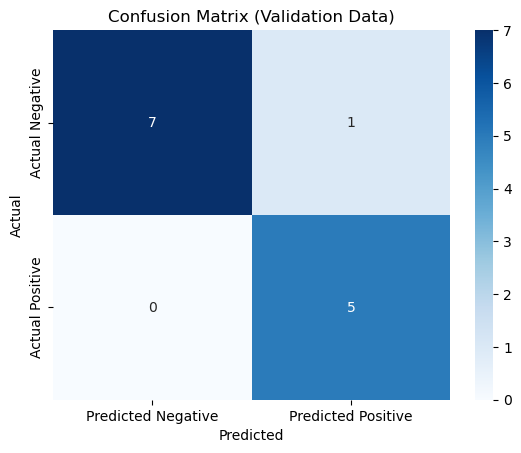

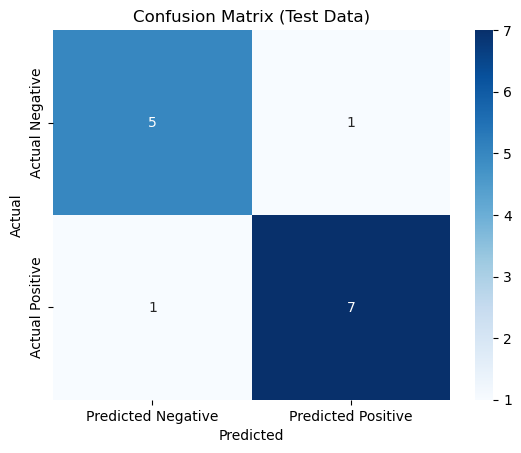

In [56]:
# Initialize MLUtils with the DataFrame
ml_utils = MLUtils(final_df)

# Set the target and feature columns
target_column = 'admittime_within_180_days' 
feature_columns = ['valuenum',
                   'bnp_outside_ref_range',
                   'n_prev_hosp_admissions',
                   'anchor_age',
                   'gender_male',
                   'race_white',
                   'race_black',
                   'race_hispanic_latino',
                   'race_asian',
                   'insurance_medicare',
                   'insurance_medicaid',
                   'marital_status_married',
                   'marital_status_single',
                   'marital_status_widowed',
                   'marital_status_divorced']

ml_utils.set_target(target_column)
ml_utils.set_features(feature_columns)

# Drop all rows where a feature or target value is NaN
ml_utils.clean_data(verbose=True)

# Split data into training, validation, and testing sets
ml_utils.split_data(ratio=(0.7, 0.15, 0.15))

# Train the model using XGBoost with SMOTE and undersampling
ml_utils.train_classification_model(smote=True, undersample_factor=0.5, verbose=True)

# Evaluate the model on validation and test datasets
validation_metrics = ml_utils.evaluate_classification_model(eval_type='val')
test_metrics = ml_utils.evaluate_classification_model(eval_type='test')

# Print evaluation metrics
display("Validation Metrics:", validation_metrics)
display("Test Metrics:", test_metrics)

ml_utils.display_confusion_matrix('val')
ml_utils.display_confusion_matrix('test')